### Introduction

Cassava is the second-largest source of carbohydrates in Africa. The goal of this project is to predict which disease a cassava plant has using image data. Specifically, we will be observing 21,367 labeled images split into 5 categories: Cassava Bacterial Blight, Cassave Brown Streak Disease, Cassava Green Mottle, Cassava Mosaic Disease, and Healthy.

This data was collected during a regular survery in Uganda, where farmers took photos of their gardens and the NAtional Crops Resource Institute annotated the images.

### Importing Libraries

In [2]:
%matplotlib notebook
import subprocess

from torchvision import transforms
from fastai.vision.all import *
from fastai.vision.widgets import *
from utils import *

from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

### Data Pre-processing

First, we must unzip the dataset downloaded from kaggle.

The data can be found here: https://www.kaggle.com/competitions/cassava-leaf-disease-classification/data

In [ ]:
# Unzip Kaggle Cassava dataset
subprocess.call('unzip cassava-leaf-disease-classification.zip', shell=True)

In [4]:
df = pd.read_csv('train.csv')
df

image_id  label
0      1000015157.jpg      0
1      1000201771.jpg      3
2       100042118.jpg      1
3      1000723321.jpg      1
4      1000812911.jpg      3
...               ...    ...
21392   999068805.jpg      3
21393   999329392.jpg      3
21394   999474432.jpg      1
21395   999616605.jpg      4
21396   999998473.jpg      4

[21397 rows x 2 columns]

Our dataset contains the names of each file and their respective labels.

The labels are as follows:
- 0: Cassava Bacterial Blight (CBB)
- 1: Cassava Brown Streak Disease (CBSD)
- 2: Cassava Green Mottle (CGM)
- 3: Cassava Mosaic Disease (CMD)
- 4: Healthy

### Train, Validation, Test Split

We will be using a train, validation and test split in this project. Our test set will remain static, while training and validation sets will be subject to change as we implement data augmentation techniques later in on in the project. A static test set is useful because it allows us to calculate an unbiased estimate of our model's performance.

**Split Percentages**:
- train: 80%
- validation: 10%
- test: 10%

In [4]:
# Sample 10%
test_set = df.sample(frac=0.1, random_state=999)

# Remove test set samples from training/validation sets
df = df.drop(test_set.index)

In [5]:
# Write test set to file
test_set.to_csv('test.csv')

In [6]:
# Check percentage of observations in test set
len(test_set) / len(df)

0.11112842083398244

### Imbalanced Classification

Since this is a classification problem we first should check if our target variable is imbalanced in our training set. An imbalanced training set can lead to a biased classifier.

3    11849
4     2333
2     2140
1     1979
0      956
Name: label, dtype: int64


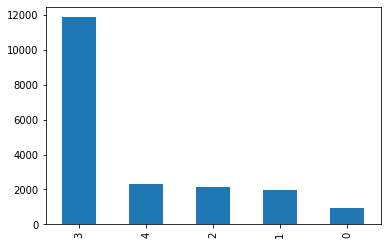

In [8]:
# Count the classes of all observations that are not in the validation set
df['label'].value_counts().plot(kind='bar')


class_counts = df['label'].value_counts(); print(class_counts)

Evidently, our training set is greatly imbalanced due to there being an overwhelming amount of records for mosaic disease. We will first attempt to train models using the imbalanced dataset and compare performance with models trained with a balanced dataset. The same test set will be used across all models.

According to the American Phytopathological Society, "cassava mosaic disease (CMD) is the most severe and widespread" disease affecting cassava plants in sub-Saharan Africa (https://www.apsnet.org/edcenter/apsnetfeatures/Pages/cassava.aspx). This is likely why we are seeing such a high number of CMD cases in our training set.

Before our neural network can interpret the data, we need to read the data using a data loader.

In [5]:
# Create data loader object for training data
cassava_diseases_dls = ImageDataLoaders.from_df(df, 'train_images', bs=64, valid_pct = 0.1)

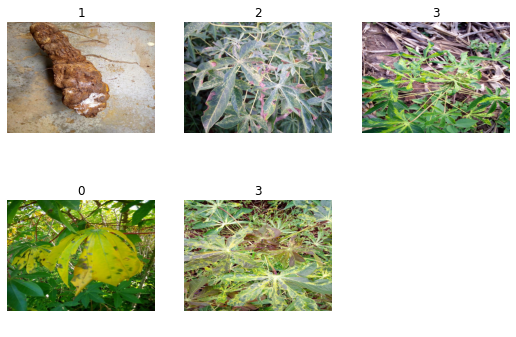

In [20]:
cassava_diseases_dls.show_batch(max_n=5)

Above are a few examples of what some of our observations look like.

### Pretrained Model & Fine tuning
For this classicafication problem, we will be utilizing a pretrained model called ResNet-18. This model is a convolutional neural network that is 18 layers deep and has been trained on over a million images from the ImageNet database. Fine tuning a pretrained model comprises of the following steps:

1) Start with a model's pretrained weights. In this case our model is pretrained on ImageNet data. The last layer's weights are removed and initialized with random weights.

2) Freeze the pretrained weights (i.e. don't update the weights) and train the last layer for one epoch.

3) Continue training and gradually unfreeze the rest of the neural network layers.

**NOTE:** We will also switch to a half-precision floating-point format to save memory while calculating activations.

In [21]:
# Create pretrained model object
learn = vision_learner(cassava_diseases_dls, resnet18, metrics=error_rate).to_fp16()

# Train for 4 epochs
learn.fine_tune(4)

### Interpreting First Model Results

Great! It looks like our model is achieving 13% error on our validation set without much tinkering. However, we might be able to perform better if we tune certain hyperparameters. The learning rate of a neural network is an important hyperparameter that dictates how quickly or aggressively the model updates its weights. Without proper tuning, our model may be learning too quickly or slowly.

In [22]:
# Save trained model to file
learn.save('cassava_leaf_disease_finetuned_resnet18')

Path('train_images/models/cassava_leaf_disease_finetuned_resnet18.pth')

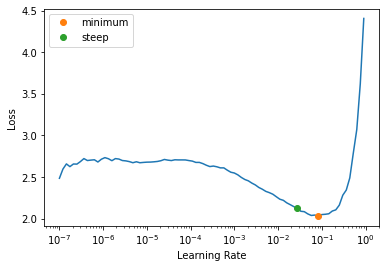

In [24]:
# Create a new pretrained model object
learn_lr_adj = vision_learner(cassava_diseases_dls, resnet18, metrics=error_rate).to_fp16()

# Plot learning rate vs loss
lr_min,lr_steep = learn_lr_adj.lr_find(suggest_funcs=(minimum, steep))

In [25]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 8.32e-03, steepest point: 2.75e-02


### Tuning the Learning Rate

The Fastai library has a built-in learning rate finder which trains a model for several epochs while continually increasing the learning rate. The loss at each epoch is recorded.

Above, we can see a plot that describes this process and can help us choose a learning rate. We don't want to choose the minimum (orange dot) since that is the point where our model is not learning anymore. Generally, we want to choose the steepest point since it is the point where our model was learning the most.

In this case, we will be choosing the minumum/10, which is slightly smaller than the steepest point.

In [26]:
# Fine tune the model again with an adjusted learning rate
learn_lr_adj.fine_tune(4, base_lr=8.32e-03)

Our model now is 89% accurate. There didn't seem to be a significant increase. This is most likely because fastai's default value for learning rate is 3e-3, which is not that different from ours.

Let's save this current model to file.

In [27]:
learn_lr_adj.save('cassava_leaf_disease_tuned_lr_resnet18')

Path('train_images/models/cassava_leaf_disease_tuned_lr_resnet18.pth')

In [6]:
# Testing purposes
learn_lr_adj = vision_learner(cassava_diseases_dls, resnet18, metrics=error_rate).to_fp16()
learn_lr_adj.load('cassava_leaf_disease_tuned_lr_resnet18')

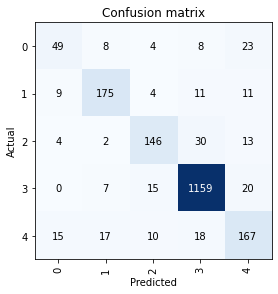

In [28]:
# Create and plot confusion matrix
interp = ClassificationInterpretation.from_learner(learn_lr_adj)
interp.plot_confusion_matrix()

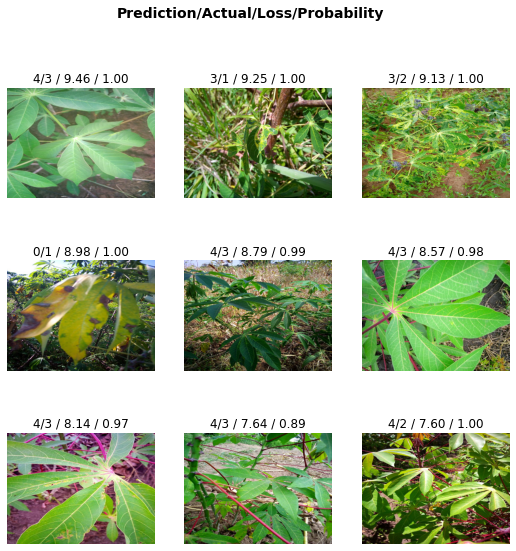

In [29]:
# Show pictures with top losses in validation
interp.plot_top_losses(50, nrows=3)

### Interpreting Confusion Matrix

A confusion matrix allows us to visualize the performanc of a classification model. We can see which classes it is most frequently "confusing". Additionally, we have generated a list of the pictures with the highest losses in our validation set.

It seems that our model is often confusing 3s (cassava mosaic disease) with 4s (healthy cassava plants). In other words, our model is thinking a plant is healthy when, in fact, it was mosaic disease. This may be due to a lack of healthy cassava plant examples in our training set which is making it difficult for our model to differentiate between classes. Images from other classes were also frequently confused for healthy plants. Before we consider how to deal with our unbalanced dataset, we will first estimate the performance of our model on the test set to compare it to later iterations.

In [13]:
# Create dataloader object for test set
test_dl = learn_lr_adj.dls.test_dl(test_set)

In [29]:
# Get predictions for test set
y_pred_tens, *_ = learn_lr_adj.get_preds(dl=test_dl)

# Change tensor of probabilities to numpy array
y_preds_mat = y_pred_tens.numpy()

# Change tensor of predictions to numpy array
y_preds = y_pred_tens.argmax(1).numpy()

In [30]:
y_preds_mat

array([[1.3216447e-04, 2.1875522e-04, 2.7148935e-03, 9.9627787e-01,
        6.5627909e-04],
       [5.4164393e-05, 3.6721111e-05, 1.5490390e-04, 9.9488562e-01,
        4.8685861e-03],
       [1.0223729e-04, 1.8530869e-04, 1.1894528e-04, 9.9928612e-01,
        3.0746788e-04],
       ...,
       [1.2827651e-03, 4.8474778e-04, 1.9225526e-04, 3.7270383e-05,
        9.9800295e-01],
       [1.4324811e-05, 2.0004903e-05, 9.7596680e-04, 9.9882692e-01,
        1.6282192e-04],
       [3.6255863e-06, 5.9892677e-06, 1.5027637e-05, 9.9984920e-01,
        1.2610164e-04]], dtype=float32)

In [31]:
# Binarize classes
y=label_binarize(test_set.label, classes=[0, 1, 2,3,4])
n_classes = y.shape[1]

# y test binary matrices 
y_test_mat = label_binarize(test_set.label, classes=[0, 1, 2,3,4])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_mat[:, i], y_preds_mat[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_mat.ravel(), y_preds_mat.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

### Calculating ROC Curve and AUC

A receiver operating characteristic curve, or ROC curve, is a plot that shows the ability of a binary classifier to discriminate between classes as the discrimination threshold is varied. An ROC curve can still be calculated for a multiclass classier however with a few caveats.

Multiclass classifiers do not have a discrimination threshold, unless we wish to turn it into a multi-label problem, so we must look at our problem from a slightly different angle to calculate our ROC curves. We will be using the "One vs Rest" method in this analysis. This method calculates ROC by comparing each class against all other classes at the same time. For example, we would take our healthy class and consider it as our "positive class", while the rest are considered as the "negative" class. In a more in-depth analysis we also may want to calculate "One vs One" ROC, which would compare each possible class pair.

Although we cannot change the discrimination threshold in a multiclass problem, we may want to set a threshold for certain classes for our model to return a message that its prediction is not confident enough. For example, if the class with the highest probability is healthy, we may want to set a confidence threshold if we feel it is important not to introduce many false positives; we don't want the farmers not to take action when their crops could potentially be sick. If our prediction is not confident enough we would simply tell the farmer that we are not sure what the status of their plant is.

<IPython.core.display.Javascript object>


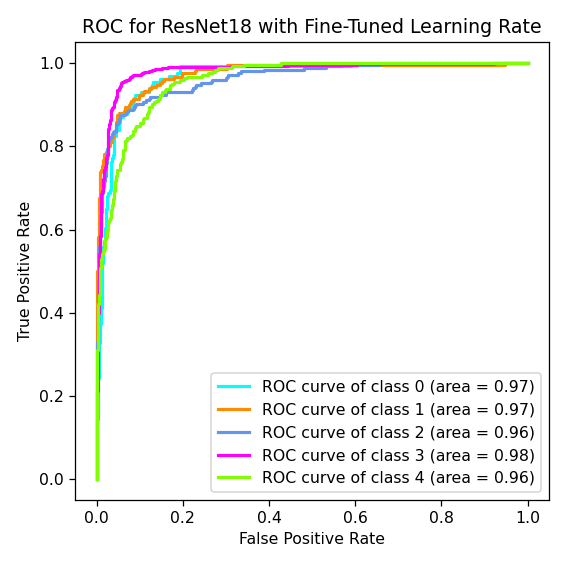

In [32]:
plt.figure(figsize=(5,5))
lw = 2

# Plot ROC curves for each class
colors = cycle(["aqua", "darkorange", "cornflowerblue", "fuchsia", "chartreuse"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for ResNet18 with Fine-Tuned Learning Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [33]:
print(classification_report(test_set.label, y_preds, target_names=['class 0','class 1','class 2','class 3','class 4']))

              precision    recall  f1-score   support

     class 0       0.68      0.60      0.63       131
     class 1       0.79      0.78      0.78       210
     class 2       0.82      0.72      0.77       246
     class 3       0.94      0.97      0.96      1309
     class 4       0.68      0.70      0.69       244

    accuracy                           0.87      2140
   macro avg       0.78      0.75      0.77      2140
weighted avg       0.87      0.87      0.87      2140



### Interpreting ROC Curve and Classification metrics

Looking at our ROC curve above, we can clearly see that we do not need a very high discrimination threshold to achieve almost 100% recall for each class; however, since this is a multiclass problem we cannot expect to tune our discrimination thresholds for optimal TPR and FPR tradeoff. 

What we can see are the classes our classifier struggles to distinguish between. Specifically, our model struggles the most with identifying class 4 (healthy) and class 1 (cassava green mottle), as these are the two classes with the lowest AUC. These results are supported by the images with the highest losses from our validation set.

Above, we have also calculated precision, recall, and f1-score using the "One vs Rest" method. Our model performed exceptionally well on class 3 data, the class with the most data, which acheived an f1-score of 0.96. This could suggest that our lackluster performance in other classes may be due to our inbalanced data. We will attempt to remediate this issue using a simple data augmentation technique. 

In [35]:
# Create a new directory for augmented training examples
subprocess.call('cp -R train_images/ train_images_augmented/', shell=True)

0

In [33]:
# Initialize augmented training set
df.to_csv('train_augmented.csv', index=False)

### Data Augmentation

A big issue deep learnining suffers from is that models usually require a lot of labeled data to work well. As we have seen above, each class in our dataset contains varying levels of data. This imbalance of data may cause our model to become biased and prevent it form generalizing to new datasets. For example, it may have trouble performing well in a dataset with a vastly different distribution of classes.

We will be using a data augmentation technique that randomly samples images in our original training set and randomly applies a transformation to the image. This process will be repeated for each class until all classes have the same amount of observations as our largest class.

We will apply the following image transformations:
- horizontal flip
- vertical flip
- center crop
- rotation
- random perspective
- color jitter

In [36]:
# Get counts for each class
class_counts = df['label'].value_counts()

# Data augmentation transforms
transform = transforms.RandomChoice([transforms.RandomHorizontalFlip(),
                                     transforms.RandomVerticalFlip(),
                                     transforms.CenterCrop((600, 800)),
                                     transforms.RandomRotation(degrees=180),
                                     transforms.RandomPerspective(.25),
                                     transforms.ColorJitter(.5,.1)],
                                     p=[1] * 6)

# Takes one row in our training set and
# writes an augmented version of the img to file
# and adds the file name to train_augmented.csv
def data_aug_one_img_rand(pair):
    img = Image.open('train_images/' + pair.iloc[0]['image_id'])
    tensor_img = transform(img)
    
    fname = str(counter) + 'augmented.jpg'
    tensor_img.save('train_images_augmented/' + fname)
    
    with open('train_augmented.csv', 'a') as f:
        f.write(fname+','+str(pair.iloc[0]['label']) + '\n')

# Loop through all classes
counter = 0
for dis in df['label'].unique():
    
    # Generate as many augmened images for each class as class 3 has
    for i in range(class_counts[3] - class_counts[dis]):
        
        # Randomly sample one row
        data_aug_one_img_rand(df[df['label']==dis].sample(n=1))
        counter += 1
    

In [34]:
df_aug = pd.read_csv('train_augmented.csv')
df_aug

image_id  label
0          1000015157.jpg      0
1           100042118.jpg      1
2          1000723321.jpg      1
3          1000812911.jpg      3
4          1000837476.jpg      3
...                   ...    ...
59240  39983augmented.jpg      2
59241  39984augmented.jpg      2
59242  39985augmented.jpg      2
59243  39986augmented.jpg      2
59244  39987augmented.jpg      2

[59245 rows x 2 columns]

<IPython.core.display.Javascript object>


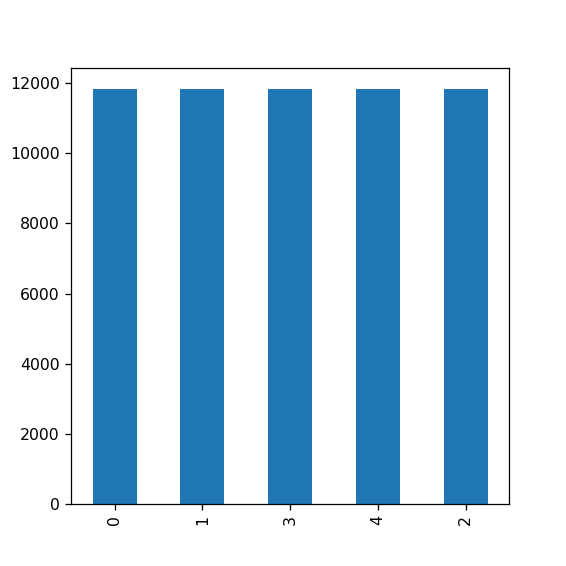

In [38]:
# Amount of samples in each class
plt.figure(figsize=(5,5))
df_aug['label'].value_counts().plot(kind='bar')
plt.show()

Great, now all of our classes are balanced.

In [40]:
cassava_diseases_aug_dls = ImageDataLoaders.from_df(df_aug, 'train_images_augmented', bs=64, valid_pct = 0.1)

<IPython.core.display.Javascript object>


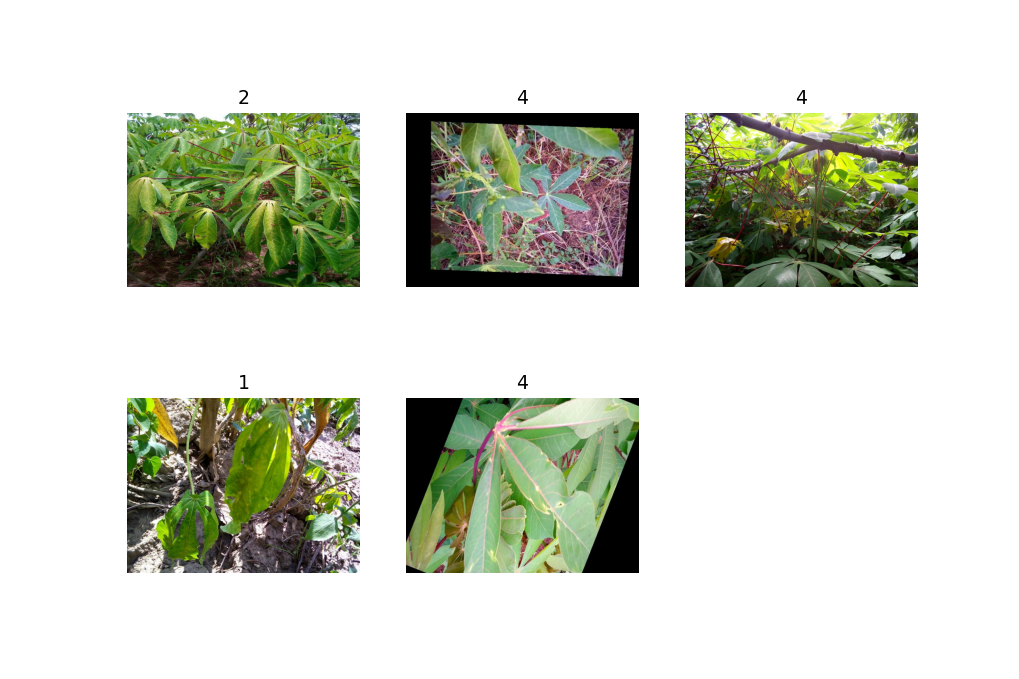

In [41]:
cassava_diseases_aug_dls.show_batch(max_n=5)

Here we can see what some of our augmented images look like; the last image shows what our rotation transformation does to our data.

<IPython.core.display.Javascript object>


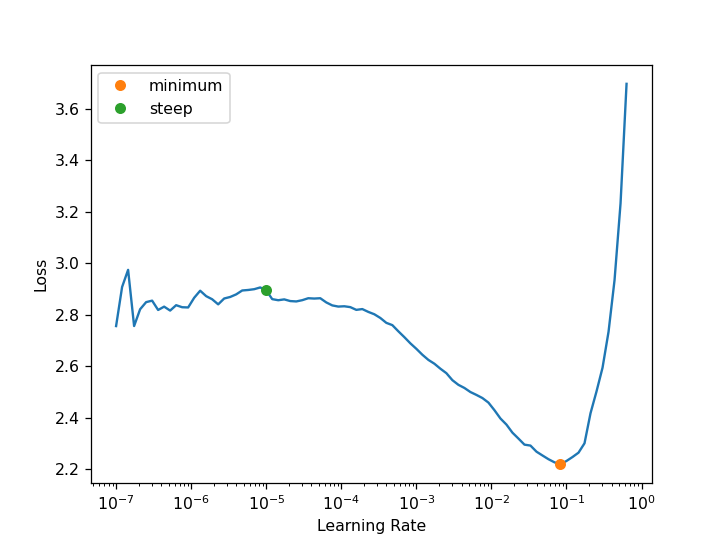

In [42]:
learn_aug = vision_learner(cassava_diseases_aug_dls, resnet18, metrics=error_rate).to_fp16()
lr_min,lr_steep = learn_aug.lr_find(suggest_funcs=(minimum, steep))

In [43]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 8.32e-03, steepest point: 1.00e-05


We will be choosing the minimum learning rate/10 as our learning rate again.

In [44]:
learn_aug.fine_tune(5, base_lr=8.32e-03)

### Interpreting Model Results on Augmented Data

Great, it seems that our model trained on augmented data is performing better on our validation set. However, our validation set in this experiment is different from our other models, so we will need to recalculate performance on our testing set to compare it to our original model.

In [45]:
# Save model to file
learn_aug.save('cassava_leaf_disease_aug_resnet18')

Path('train_images_augmented/models/cassava_leaf_disease_aug_resnet18.pth')

In [42]:
# Reload model saved to file (in case kernel is disrupted)
cassava_diseases_aug_dls = ImageDataLoaders.from_df(df_aug, 'train_images_augmented', bs=64, valid_pct = 0.1)
learn_aug= vision_learner(cassava_diseases_aug_dls, resnet18, metrics=error_rate).to_fp16()
learn_aug.load('cassava_leaf_disease_aug_resnet18')

<IPython.core.display.Javascript object>


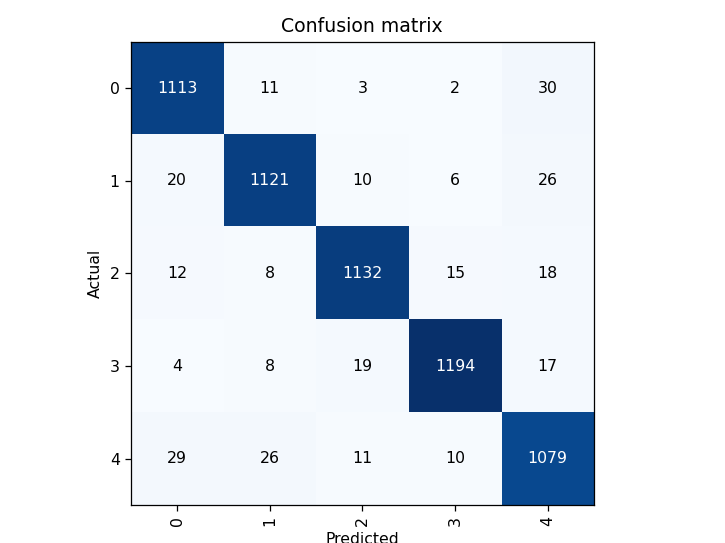

In [46]:
interp = ClassificationInterpretation.from_learner(learn_aug)
interp.plot_confusion_matrix()

### Interpreting Confusion Matrix of Augmented Data Model

Similar to the model trained without augmented data, it seems that most of our error stems from misclassifying unhealthy plants as healthy--even more in our augmented dataset. Unfortunately, it seems that our data augmentation technique made this issue slighly worse. Overall, it does not seem like there was a major improvement in performance.

<IPython.core.display.Javascript object>


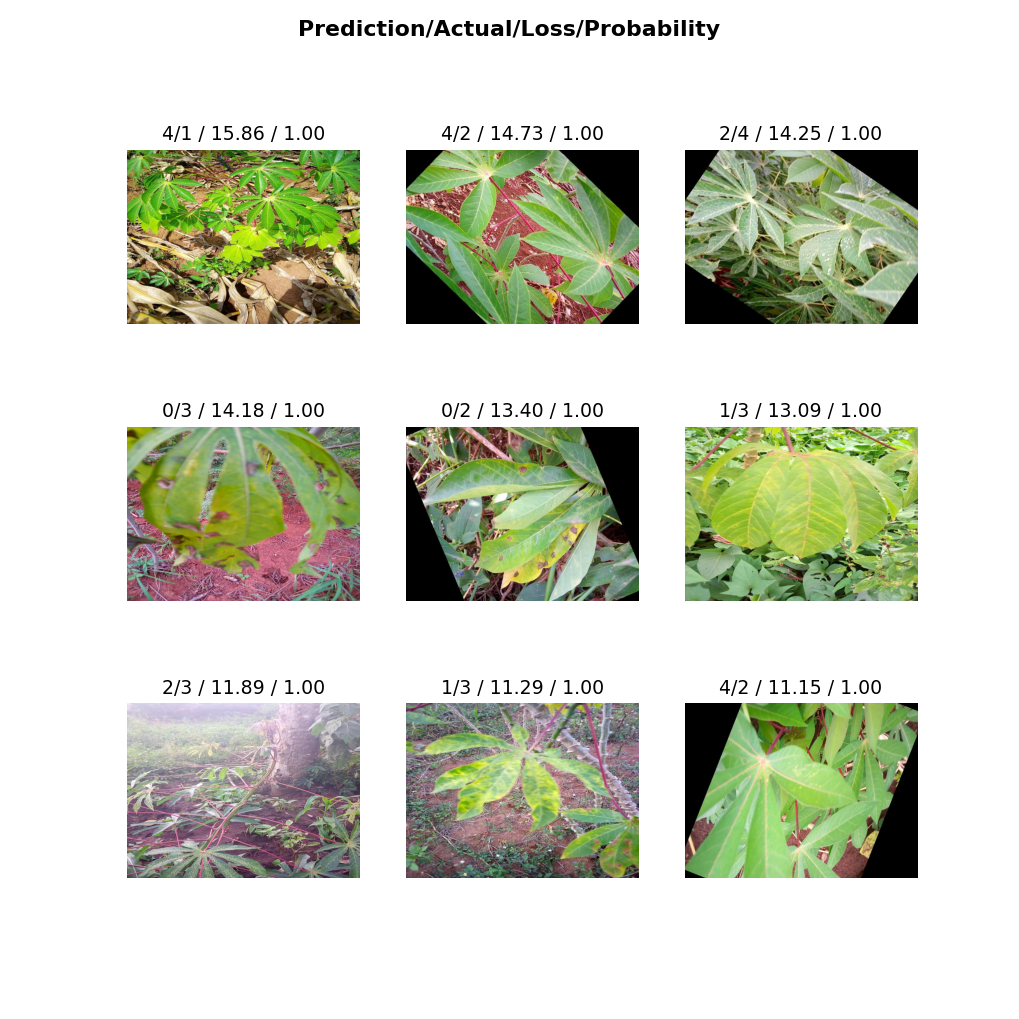

In [47]:
interp.plot_top_losses(50, nrows=3)

As mentioned above, we can see that the images with the highest losses are still those plants that were predicted to be healthy but have a disease.

In [43]:
# Create dataloader object for test set
test_dl = learn_aug.dls.test_dl(test_set)

In [44]:
# Get predictions for test set
y_pred_tens, *_ = learn_aug.get_preds(dl=test_dl)

# Change tensor of probabilities to numpy array
y_preds_mat = y_pred_tens.numpy()

# Change tensor of predictions to numpy array
y_preds = y_pred_tens.argmax(1).numpy()

In [38]:
y_preds_mat

array([[1.3216447e-04, 2.1875522e-04, 2.7148935e-03, 9.9627787e-01,
        6.5627909e-04],
       [5.4164393e-05, 3.6721111e-05, 1.5490390e-04, 9.9488562e-01,
        4.8685861e-03],
       [1.0223729e-04, 1.8530869e-04, 1.1894528e-04, 9.9928612e-01,
        3.0746788e-04],
       ...,
       [1.2827651e-03, 4.8474778e-04, 1.9225526e-04, 3.7270383e-05,
        9.9800295e-01],
       [1.4324811e-05, 2.0004903e-05, 9.7596680e-04, 9.9882692e-01,
        1.6282192e-04],
       [3.6255863e-06, 5.9892677e-06, 1.5027637e-05, 9.9984920e-01,
        1.2610164e-04]], dtype=float32)

In [45]:
# Binarize classes
y=label_binarize(test_set.label, classes=[0, 1, 2,3,4])
n_classes = y.shape[1]

# y test and y preds binary matrices 
y_test_mat = label_binarize(test_set.label, classes=[0, 1, 2,3,4])


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_mat[:, i], y_preds_mat[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_mat.ravel(), y_preds_mat.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

<IPython.core.display.Javascript object>


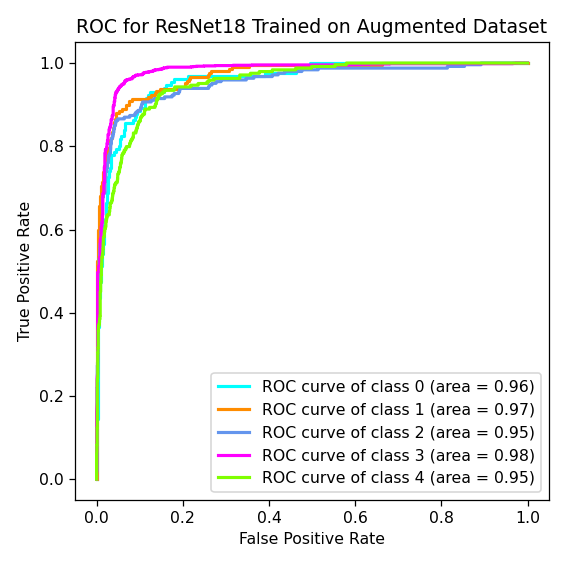

In [46]:
plt.figure(figsize=(5,5))
lw = 2

# Plot ROC curves for each class
colors = cycle(["aqua", "darkorange", "cornflowerblue", "fuchsia", "chartreuse"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for ResNet18 Trained on Augmented Dataset")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [47]:
print(classification_report(test_set.label, y_preds, target_names=['class 0','class 1','class 2','class 3','class 4']))

              precision    recall  f1-score   support

     class 0       0.66      0.63      0.65       131
     class 1       0.83      0.74      0.78       210
     class 2       0.80      0.74      0.77       246
     class 3       0.95      0.96      0.96      1309
     class 4       0.65      0.73      0.69       244

    accuracy                           0.87      2140
   macro avg       0.78      0.76      0.77      2140
weighted avg       0.87      0.87      0.87      2140



### Interpreting ROC Curve and Classification metrics for Data Augmentation Model

Overall, there are no major improvements observered in either ROC AUC or other classification metrics. In fact, we actually observe a slight decrease in ROC AUC for classes 0, 2, and 4. This may suggest that our model trained on augmented data struggles slightly more to differentiate these classes versus the rest of the classes. We also observe slight variations in the rest of our classification metrics (precision, recall, etc...), but there are no major deviations from our initial performance. We can therefore conclude that our models with and without augmented data perform more or less the same.

### Creating a Baseline Model

After performing all this fancy modeling, we would like to see how our models perform against a simple modeling method, also known as a baseline model. Since our images are just rank 3 tensors filled with integers from 0 to 255, we will be creating a model that will calculate the average tensor for each class, and then calculate the distance between each average to each observation in our training set. The average class tensor that is closest will be chosen as the predicted class. We will be using an L1 loss function to calculate the distance between images.

In [5]:
cassava_diseases_baseline_dls = ImageDataLoaders.from_df(df_aug, 'train_images_augmented', bs=64, valid_pct = 0.)

In [5]:
# Set path for augmented images
p = 'train_images_augmented/'

def calc_mean_tensor(lab, path):
    
        # Create a list of tensors for the class
        disease_tens_list = [tensor(Image.open(path + o)) 
                         for o in df_aug[(df_aug['label'] == lab) & 
                                         (df_aug['image_id'].str.contains('augmented') == False)]['image_id'][:500]]
        
        # Stack all tensors and divide by 255
        stacked_disease_tensors = torch.stack(disease_tens_list).float()/255
        
        return stacked_disease_tensors.mean(0)

mean0 = calc_mean_tensor(0, p)
mean1 = calc_mean_tensor(1, p)
mean2 = calc_mean_tensor(2, p)
mean3 = calc_mean_tensor(3, p)
mean4 = calc_mean_tensor(4, p)

**Note:** Due to a lack of resources, we will only be using the first 500 images in each class to calculate the mean tensor. The lack of data in our baseline model will most likely bias our performance results. Ideally, in an environment with more memory and GPUs, we would like to use the entire dataset for our baseline model.

<IPython.core.display.Javascript object>


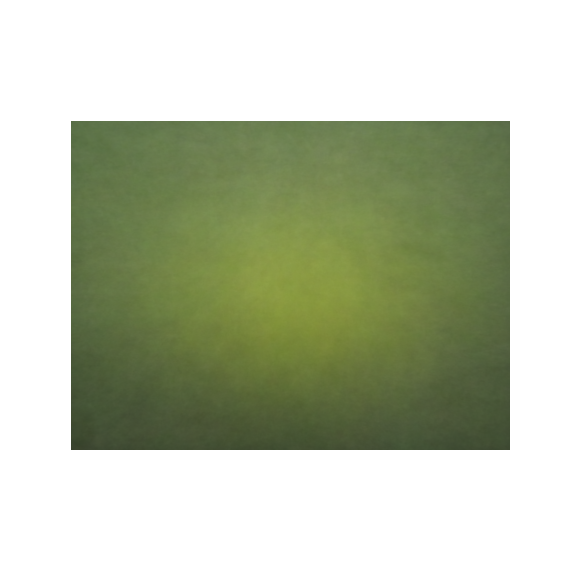

<IPython.core.display.Javascript object>


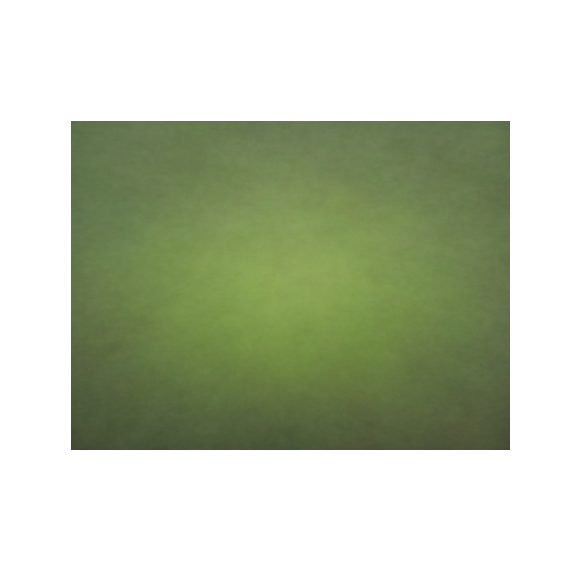

<AxesSubplot:>

In [15]:
show_image(mean0); show_image(mean1)

Above, we can see the average tensors for classes 0 and 1, respectively. We cannot really distinguish any shapes within our averaged tensors; however, we can observe that one tensor is lighter than the other. Maybe our baseline model will be able to distinguish between classes using the lightness of the image.

Now, we will calculate classification ROC curves for our baseline model.

In [49]:
# Function for generating a prediction for a single image using baseline models
def baseline_pred(img, path, means):
    
    # Convert image to tensor
    tens_img = tensor(Image.open(path + img)).float()/255
    
    # Calculate loss from means
    losses = []
    for mean in means:
        losses.append(F.mse_loss(tens_img, mean).item())
    
    # Return class that had lowest loss
    return losses.index(min(losses))

# Create list of predictions using baseline model
y_preds = [baseline_pred(obv, p, [mean0, mean1, mean2, mean3, mean4]) for obv in test_set['image_id']]

In [50]:
# Binarize classes
y=label_binarize(test_set.label, classes=[0, 1, 2,3,4])
n_classes = y.shape[1]

# y test and y preds binary matrices 
y_test_mat = label_binarize(test_set.label, classes=[0, 1, 2,3,4])
y_preds_mat = label_binarize(y_preds, classes=[0, 1, 2,3,4])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_mat[:, i], y_preds_mat[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_mat.ravel(), y_preds_mat.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

<IPython.core.display.Javascript object>


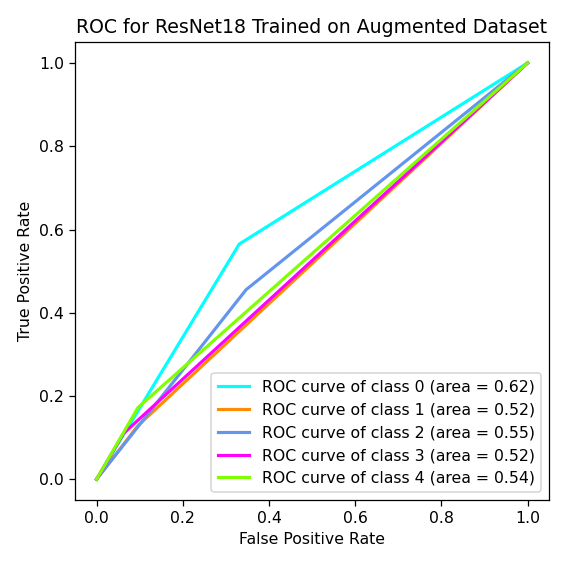

In [51]:
plt.figure(figsize=(5,5))
lw = 2

# Plot ROC curves for each class
colors = cycle(["aqua", "darkorange", "cornflowerblue", "fuchsia", "chartreuse"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for ResNet18 Trained on Augmented Dataset")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [52]:
print(classification_report(test_set.label, y_preds, target_names=['class 0','class 1','class 2','class 3','class 4']))

              precision    recall  f1-score   support

     class 0       0.10      0.56      0.17       131
     class 1       0.13      0.13      0.13       210
     class 2       0.15      0.46      0.22       246
     class 3       0.73      0.11      0.19      1309
     class 4       0.19      0.17      0.18       244

    accuracy                           0.19      2140
   macro avg       0.26      0.29      0.18      2140
weighted avg       0.51      0.19      0.19      2140



### Interpreting ROC Curve and Classification metrics for Baseline

As expected, our baseline models did not perform as well as our neural networks. The ROC curve suggests that they are only slightly better than a random classifier. This is good because it means all of the effort we went through to create these models was not wasted. 

A next comparison we would like to make would be to test how our neural network model performs compared to a human's performance. If we observe that a plant expert makes similar mistakes that our neural network model does, we can confidently say that we have a pretty good model. Additionally, it could be that our error is coming from images that are inherently hard to classify due to poor lighting, poor resolution, or other factors; however, since our testing set was generated randomly this pattern should also be present in our training set on which our neural network achieved 1% error.

Overall, this analysis suggests that our model is performing decently well although we may want to address some possible concerns before putting it into production:
- How does the model perform against humans?
- Should we return a message if our prediction is not confident enough?
- How do we want to deal with the recall/precision trade-off? Would we rather avoid having false positives than having more true positives?